In [1]:
import torch
from torch.utils.data import DataLoader, Subset
import torchaudio
import matplotlib.pyplot as plt
import librosa
import soundfile as sf

from custom_audio_dataset import BirdAudioDataset

AUDIO_FILE = "20210816T063139-0500_Rec.wav"
SAMPLE_RATE = 22050
NUM_SAMPLES = 22050
CROP_FREQUENCIES = False

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(f"Using {device} device")

mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=SAMPLE_RATE, n_fft=1024, hop_length=512, n_mels=64
)

bad = BirdAudioDataset(
    AUDIO_FILE, mel_spectrogram, SAMPLE_RATE, NUM_SAMPLES, device, 20, False
)

Using cpu device
Original sample rate of audio is 44100 Hz
Loading 20 seconds of audio...
Audio loaded!



In [2]:
def plot_spectrograms(start_frame, end_frame):

    # Load in data subset based on start_frame and end_frame
    bad_subset = Subset(bad, range(start_frame, end_frame))
    dataloader = DataLoader(bad_subset, batch_size=1)
    num_frames = end_frame - start_frame

    # Set up grayscale figure
    fig_scale = 3
    fig, axes = plt.subplots(nrows=1, ncols=num_frames, figsize=(num_frames * fig_scale, fig_scale))
    fig.tight_layout()
    plt.gray()
    
    # Add subplot for each original spectrogram and reconstruction
    for i, img in enumerate(dataloader):
        
        print(f"Processing sample: {i + 1}/{len(dataloader)}", end='\r')
        axes[i].imshow(img[0][0], cmap="plasma")
    
    print()

    # Save figure
    figure_save_path = "spectrograms.png"
    plt.savefig(figure_save_path)
    print(f"Saved figure at path: {figure_save_path}")

In [3]:
import os
import numpy as np

def save_audio(start_frame, end_frame, frequency_cropped=False):

    time_series_imgs = np.array([])

    # Load in data subset based on start_frame and end_frame
    bad_subset = Subset(bad, range(start_frame, end_frame))
    dataloader = DataLoader(bad_subset, batch_size=1)
    
    audio_save_path = "sounds"
    os.makedirs(audio_save_path, exist_ok=True)
    
    # Save audio for each original spectrogram
    for i, img in enumerate(dataloader):
        
        print(f"Processing sample: {i + 1}/{len(dataloader)}", end='\r')

        if frequency_cropped:
            frequency_padding = (0, 0, 64, 0)
            img = torch.nn.functional.pad(img, frequency_padding)

        time_series_img = librosa.feature.inverse.mel_to_audio(
            img[0][0].detach().numpy(), sr=SAMPLE_RATE, n_fft=1024, hop_length=512
        )
        time_series_imgs = np.concatenate((time_series_imgs, time_series_img))

        sf.write(f"{audio_save_path}/audio_img{i}.wav", time_series_img, SAMPLE_RATE)

    sf.write(f"{audio_save_path}/audio_img_tog.wav", time_series_imgs, SAMPLE_RATE)
        
    print()
    print(f"Saved audio files at path: {audio_save_path}")

Processing sample: 20/20
Saved figure at path: spectrograms.png


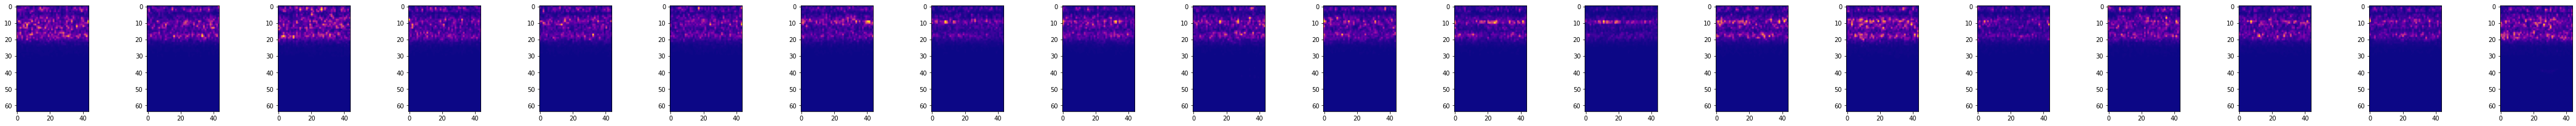

In [4]:
with torch.no_grad():
    plot_spectrograms(0, 20)

In [5]:
with torch.no_grad():
    save_audio(0, 20, True)

Processing sample: 20/20
Saved audio files at path: sounds
